In [1]:
# all the imports used throughout the notebook:
import json
import pandas as pd
import numpy as np
import wrangle
import acquire
import model
from prepare import basic_clean, tokenize, lemmatize, stem, remove_stopwords, prep_string_data#, split_data
import scipy as sp
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import nltk

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
eval_df, train, validate, test = model.run_modeling()

The df has 1889857 rows and 12 columns.
train shape is (42327, 13)
validate shape is (18141, 13)
test shape is (15118, 13)
Basic Splits Created
TF_IDF Splits Created
Count Vectorizer Splits Created
Logistic Regression Beginning
LR done
Decision Tree beginning
DT done
Random Forest beginning
RF done


In [3]:
eval_df

,Model_Type,Train_Accuracy,Validate_Accuracy,Accuracy_Difference,Beats_Baseline_By
0,baseline_pred,0.496397,0.496389,0.000008,-0.004225
0,Log_Reg_Just_Features,0.621022,0.622292,-0.001270,0.121678
0,Log_Reg_Just_TFIDF,0.808751,0.737446,0.071305,0.236832
0,Log_Reg_TFIDF_Plus_Features,0.743379,0.731547,0.011832,0.230933
0,Log_Reg_CV,0.850261,0.719475,0.130786,0.218861
0,Log_Reg_CV_Plus_Features,0.748435,0.736288,0.012147,0.235674
0,Decision_Tree_Just_Features,0.685355,0.686787,-0.001432,0.186173
0,DecisionTree_Just_TFIDF,0.625653,0.620418,0.005235,0.119804
0,Decision_Tree_TFIDF_PlusFeatures,0.693387,0.698032,-0.004645,0.197418
0,DecisionTree_Just_Countvectorizer,0.613226,0.606582,0.006644,0.105968


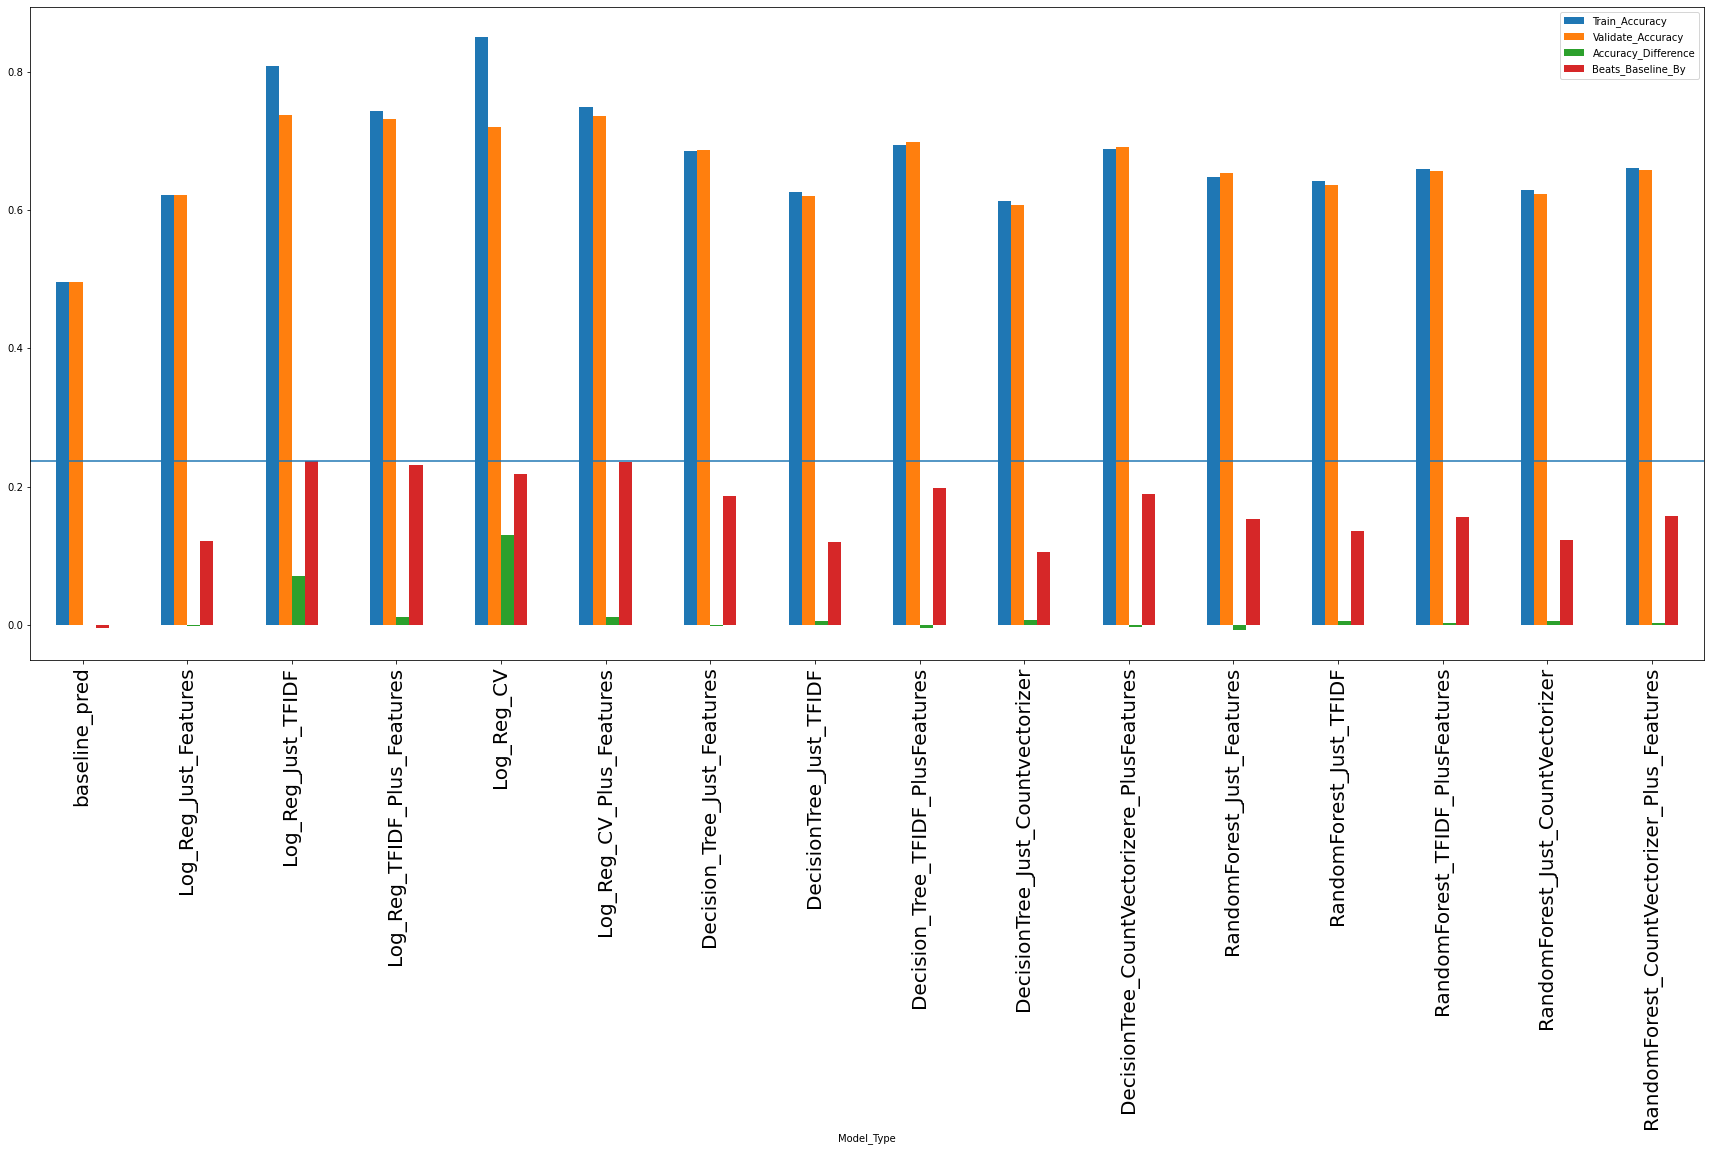

In [4]:
# define columns of eval df for use plotting below
columns = ['Train_Accuracy', 'Validate_Accuracy','Accuracy_Difference', 'Beats_Baseline_By']
columns
# plot all the results, grouped by model
eval_df.plot(x='Model_Type', y=columns, kind="bar", figsize=(30,12))

plt.legend#(loc=(1.01,1.2), bbox_to_anchor=(.5, 0., .5, .5))
# ax.xaxis.set_tick_params(labelsize=20)
# ax.yaxis.set_tick_params(labelsize=20)

# add h line for highest gross performing model
plt.axhline(y=eval_df.Beats_Baseline_By.max())
plt.xticks(rotation=90, fontsize=20);

## The best model in our opionion is the Logistic Regression on Count Vectorizer plus additional Features

## Running this model on TEST

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()

In [7]:
print('Train Accuracy, Countvectorizer_PlusFeatures: {:.2%}'.format(accuracy_score(train.actual, train.predicted_X_cv_plus_features)))
print('---')
# print('Confusion Matrix')
# print(pd.crosstab(train.predicted, train.actual))
# print('---')
print('Validate Accuracy, Countvectorizer_PlusFeatures: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_X_cv_plus_features)))
print('---')

print('Test Accuracy, Countvectorizer_PlusFeatures: {:.2%}'.format(accuracy_score(test.actual, test.predicted_X_cv_plus_features)))
print(classification_report(test.actual, test.predicted_X_cv_plus_features))


Train Accuracy, Countvectorizer_PlusFeatures: 74.84%
---
Validate Accuracy, Countvectorizer_PlusFeatures: 73.63%
---
Test Accuracy, Countvectorizer_PlusFeatures: 73.28%
              precision    recall  f1-score   support

       False       0.74      0.72      0.73      7613
        True       0.72      0.74      0.73      7505

    accuracy                           0.73     15118
   macro avg       0.73      0.73      0.73     15118
weighted avg       0.73      0.73      0.73     15118



### That's a 73% accuracy classifying 'is_host' (75% when running on 500_000 rows)
### This beats baseline by 23%